In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import random  
import numpy as np
import seaborn as sns
from scipy import stats
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
plt.style.use("seaborn")
import warnings
warnings.filterwarnings('ignore')
from scipy import stats  
  
def jude_KS(data):  
    u =data.mean()  # 计算均值  
    std=data.std() ##计算标准差  
    p=stats.kstest(data, 'norm', (u, std))  
    return p

plt.rcParams['font.sans-serif'] = [u'SimHei']
plt.rcParams['axes.unicode_minus'] = False

{'whiskers': [<matplotlib.lines.Line2D at 0x2323c1bc970>,
 'caps': [<matplotlib.lines.Line2D at 0x2323c1bcf10>,
 'boxes': [<matplotlib.lines.Line2D at 0x2323c1bc6a0>],
 'medians': [<matplotlib.lines.Line2D at 0x2323c1d24f0>],
 'fliers': [<matplotlib.lines.Line2D at 0x2323c1d27c0>],
 'means': []}

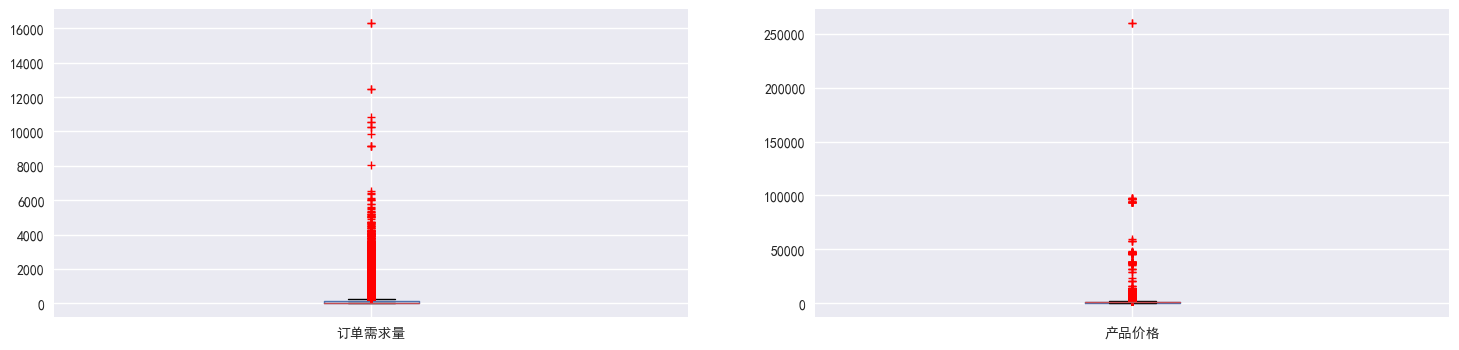

In [2]:
data = pd.read_csv('./数据预处理后的文件.csv')
final_test_df = pd.read_csv('./predict_sku1.csv')
data = data.iloc[:,1:]
fig,ax = plt.subplots(1,2,figsize=(18,4))
data['订单需求量'].plot.box(sym='r+',return_type='dict',ax=ax[0])
data['产品价格'].plot.box(sym='r+',return_type='dict',ax=ax[1])

In [3]:
data[data.duplicated (keep=False)]

,订单日期,销售区域编码,产品编码,产品大类编码,产品细类编码,销售渠道名称,产品价格,季节,月时间段,促销期,是否为节假日,订单需求量
1751,2015-09-10,103,20092,306,407,0,739.0,3,1,0,0,107
1786,2015-09-10,103,20092,306,407,0,739.0,3,1,0,0,107
1990,2015-09-11,102,21745,303,401,0,1713.0,3,2,0,0,37
2143,2015-09-11,102,21745,303,401,0,1713.0,3,2,0,0,37
4958,2015-09-19,103,21413,303,401,0,1414.0,3,2,0,1,32
...,...,...,...,...,...,...,...,...,...,...,...,...
591119,2018-12-12,103,20253,306,407,0,539.0,4,2,1212,0,9
594494,2018-12-17,103,20215,302,408,0,1962.0,4,2,0,0,6
594502,2018-12-17,103,20215,302,408,0,1962.0,4,2,0,0,6
597098,2018-12-20,103,21394,306,407,0,736.0,4,2,0,0,8


In [4]:
# create time series period features
def time_period_features(df, time_col):
    # month level
    df['month'] = df['订单日期'].dt.month
    # quarter level
    df['quarter'] = df['订单日期'].dt.quarter
    # year level
    df['year'] = df['订单日期'].dt.year
    df['week']  = df['订单日期'].dt.week
    return df

data['订单日期'] = pd.to_datetime(data['订单日期'])
all_info_df = time_period_features(data, 'date')
print(all_info_df.info())
all_info_df
# cols = all_info_df.columns.tolist()
# cols.append(cols.pop(cols.index('产品价格')))
# all_info_df = all_info_df.reindex(columns=cols)
# all_info_df=all_info_df.rename(columns={'产品价格':'e'})
all_info_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 597694 entries, 0 to 597693
Data columns (total 16 columns):
 #   Column   Non-Null Count   Dtype         
---  ------   --------------   -----         
 0   订单日期     597694 non-null  datetime64[ns]
 1   销售区域编码   597694 non-null  int64         
 2   产品编码     597694 non-null  int64         
 3   产品大类编码   597694 non-null  int64         
 4   产品细类编码   597694 non-null  int64         
 5   销售渠道名称   597694 non-null  int64         
 6   产品价格     597694 non-null  float64       
 7   季节       597694 non-null  int64         
 8   月时间段     597694 non-null  int64         
 9   促销期      597694 non-null  int64         
 10  是否为节假日   597694 non-null  int64         
 11  订单需求量    597694 non-null  int64         
 12  month    597694 non-null  int64         
 13  quarter  597694 non-null  int64         
 14  year     597694 non-null  int64         
 15  week     597694 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(14)
memory usage

,订单日期,销售区域编码,产品编码,产品大类编码,产品细类编码,销售渠道名称,产品价格,季节,月时间段,促销期,是否为节假日,订单需求量,month,quarter,year,week
0,2015-09-01,104,22069,307,403,0,1114.0,3,1,0,0,19,9,3,2015,36
1,2015-09-01,104,20028,301,405,0,1012.0,3,1,0,0,12,9,3,2015,36
2,2015-09-02,104,21183,307,403,1,428.0,3,1,0,0,109,9,3,2015,36
3,2015-09-02,104,20448,308,404,1,962.0,3,1,0,0,3,9,3,2015,36
4,2015-09-02,104,21565,307,403,0,1400.0,3,1,0,0,3,9,3,2015,36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
597689,2018-12-20,102,20994,302,408,0,843.0,4,2,0,0,59,12,4,2018,51
597690,2018-12-20,102,21875,302,408,0,762.0,4,2,0,0,502,12,4,2018,51
597691,2018-12-20,102,20215,302,408,0,2013.0,4,2,0,0,106,12,4,2018,51
597692,2018-12-20,102,20195,302,408,0,2120.0,4,2,0,0,187,12,4,2018,51


In [5]:
sales_per_month = pd.pivot_table(
    data=all_info_df, values=[
       u'订单需求量', u'产品价格'], index=[
            '销售区域编码', '产品编码', '产品大类编码','产品细类编码'], columns=[
                'year','month','week'], aggfunc={
                    '订单需求量': 'sum', '产品价格': 'mean'})
sales_per_month.fillna(value=0,inplace=True)
# print(sales_per_month.info())
# col_order=[('产品价格', 2015, 36),
 

#sales_per_month=sales_per_month.reindex(col_order, axis=1)
sales_per_month

产品价格                                             \
year                         2015                                              
month                          9                              10               
week                           36     37     38     39   40   40          41   
销售区域编码 产品编码  产品大类编码 产品细类编码                                                     
101    20001 302    408       0.0    0.0    0.0    0.0  0.0  0.0    0.000000   
       20002 303    406       0.0    0.0    0.0    0.0  0.0  0.0    0.000000   
       20003 301    405       0.0    0.0    0.0    0.0  0.0  0.0    0.000000   
       20005 306    407       0.0    0.0    0.0    0.0  0.0  0.0    0.000000   
       20006 307    403       0.0    0.0    0.0    0.0  0.0  0.0    0.000000   
...                           ...    ...    ...    ...  ...  ...         ...   
105    22080 306    407     626.0  631.2  636.6  638.0  0.0  0.0  635.857143   
       22081 303    401       0.0    0.0    0.0    0.0  0.0  0.0    0.000000   
       22082 305    412       0.0    0.0    0.0    0.0  0.0  0.0    0.000000   
       22083 303    401       0.0    0.0    0.0    0.0  0.0  0.0    0.000000   
       22084 302    408       0.0    0.0    0.0    0.0  0.0  0.0    0.000000   

                                                      ... 订单需求量               \
year                                                  ...  2018                
month                                                 ...    10    11          
week                           42          43     44  ...    44    44     45   
销售区域编码 产品编码  产品大类编码 产品细类编码                            ...                      
101    20001 302    408       0.0    0.000000    0.0  ...   0.0   0.0    0.0   
       20002 303    406       0.0    0.000000    0.0  ...   0.0   3.0   24.0   
       20003 301    405       0.0    0.000000    0.0  ...   0.0   0.0    0.0   
       20005 306    407       0.0    0.000000    0.0  ...   0.0   0.0    0.0   
       20006 307    403       0.0    0.000000    0.0  ...   0.0  25.0    0.0   
...                           ...         ...    ...  ...   ...   ...    ...   
105    22080 306    407     633.4  635.166667  635.6  ...   0.0   0.0    0.0   
       22081 303    401       0.0    0.000000    0.0  ...   9.0   0.0    0.0   
       22082 305    412       0.0    0.000000    0.0  ...   0.0   0.0    0.0   
       22083 303    401       0.0    0.000000    0.0  ...  20.0  55.0  112.0   
       22084 302    408       0.0    0.000000    0.0  ...   0.0   0.0    0.0   

                                                                           
year                                                                       
month                                              12                      
week                           46     47    48     48     49     50    51  
销售区域编码 产品编码  产品大类编码 产品细类编码                                                 
101    20001 302    408       0.0    0.0   0.0    0.0    0.0    0.0   0.0  
       20002 303    406       0.0    0.0   9.0    0.0    0.0   42.0  14.0  
       20003 301    405       0.0    0.0   0.0    0.0    0.0    0.0  85.0  
       20005 306    407       0.0    0.0   0.0    0.0    0.0    0.0   0.0  
       20006 307    403       0.0    0.0   0.0    0.0    0.0  119.0   0.0  
...                           ...    ...   ...    ...    ...    ...   ...  
105    22080 306    407       0.0    0.0   0.0    0.0    0.0   16.0   0.0  
       22081 303    401       8.0    7.0   0.0    0.0    0.0    7.0   0.0  
       22082 305    412       0.0    0.0   0.0    0.0    0.0    0.0   0.0  
       22083 303    401     901.0  229.0  47.0  723.0  261.0   84.0  56.0  
       22084 302    408       0.0    0.0   0.0    0.0    0.0    0.0   0.0  

[5366 rows x 408 columns]

In [6]:
sales_per_month.info()


<class 'pandas.core.frame.DataFrame'>
MultiIndex: 5366 entries, (101, 20001, 302, 408) to (105, 22084, 302, 408)
Columns: 408 entries, ('产品价格', 2015, 9, 36) to ('订单需求量', 2018, 12, 51)
dtypes: float64(408)
memory usage: 16.7 MB


In [7]:
sales_per_month.fillna(0, inplace=True)
sales_per_month.reset_index(inplace=True)
sales_per_month

销售区域编码   产品编码 产品大类编码 产品细类编码   产品价格                                 ...  \
year                                2015                                 ...   
month                                  9                             10  ...   
week                                  36     37     38     39   40   40  ...   
0        101  20001    302    408    0.0    0.0    0.0    0.0  0.0  0.0  ...   
1        101  20002    303    406    0.0    0.0    0.0    0.0  0.0  0.0  ...   
2        101  20003    301    405    0.0    0.0    0.0    0.0  0.0  0.0  ...   
3        101  20005    306    407    0.0    0.0    0.0    0.0  0.0  0.0  ...   
4        101  20006    307    403    0.0    0.0    0.0    0.0  0.0  0.0  ...   
...      ...    ...    ...    ...    ...    ...    ...    ...  ...  ...  ...   
5361     105  22080    306    407  626.0  631.2  636.6  638.0  0.0  0.0  ...   
5362     105  22081    303    401    0.0    0.0    0.0    0.0  0.0  0.0  ...   
5363     105  22082    305    412    0.0    0.0    0.0    0.0  0.0  0.0  ...   
5364     105  22083    303    401    0.0    0.0    0.0    0.0  0.0  0.0  ...   
5365     105  22084    302    408    0.0    0.0    0.0    0.0  0.0  0.0  ...   

      订单需求量                                                              
year   2018                                                              
month    10    11                                12                      
week     44    44     45     46     47    48     48     49     50    51  
0       0.0   0.0    0.0    0.0    0.0   0.0    0.0    0.0    0.0   0.0  
1       0.0   3.0   24.0    0.0    0.0   9.0    0.0    0.0   42.0  14.0  
2       0.0   0.0    0.0    0.0    0.0   0.0    0.0    0.0    0.0  85.0  
3       0.0   0.0    0.0    0.0    0.0   0.0    0.0    0.0    0.0   0.0  
4       0.0  25.0    0.0    0.0    0.0   0.0    0.0    0.0  119.0   0.0  
...     ...   ...    ...    ...    ...   ...    ...    ...    ...   ...  
5361    0.0   0.0    0.0    0.0    0.0   0.0    0.0    0.0   16.0   0.0  
5362    9.0   0.0    0.0    8.0    7.0   0.0    0.0    0.0    7.0   0.0  
5363    0.0   0.0    0.0    0.0    0.0   0.0    0.0    0.0    0.0   0.0  
5364   20.0  55.0  112.0  901.0  229.0  47.0  723.0  261.0   84.0  56.0  
5365    0.0   0.0    0.0    0.0    0.0   0.0    0.0    0.0    0.0   0.0  

[5366 rows x 412 columns]

In [8]:
print(sales_per_month.shape)

(5366, 412)


In [9]:
print(sales_per_month.shape)
print(final_test_df.shape)

(5366, 412)
(2619, 4)


In [10]:
def set_index(data_first):
    data_second = data_first.iloc[:,:]
    data_second=data_second.rename(columns={'order_date':'订单日期','sales_region_code':'销售区域编码','item_code':'产品编码',
                                           'first_cate_code':'产品大类编码','second_cate_code':'产品细类编码',
                                            'sales_chan_name':'销售渠道名称','item_price':'产品价格','ord_qty':'订单需求量'})
#     data_second.columns=['订单日期','销售区域编码','产品编码','产品大类编码','产品细类编码','销售渠道名称','产品价格','订单需求量']
    return data_second
final_test_df=set_index(final_test_df)
final_test_df

,销售区域编码,产品编码,产品大类编码,产品细类编码
0,101,20002,303,406
1,101,20003,301,405
2,101,20006,307,403
3,101,20011,303,401
4,101,20014,307,403
...,...,...,...,...
2614,105,22066,307,403
2615,105,22072,305,412
2616,105,22075,307,403
2617,105,22083,303,401


In [11]:
data.sort_values(by=['销售区域编码','产品编码'])

# 提取四个标签的种类
labels = ['销售区域编码', '产品编码', '产品大类编码', '产品细类编码']
label_groups = data[labels].groupby(labels).groups

# 得到所有组合类型
combinations = [list(group) for group in label_groups.keys()]

# 将组合类型转换为 DataFrame
df = pd.DataFrame(combinations, columns=labels)
df

,销售区域编码,产品编码,产品大类编码,产品细类编码
0,101,20001,302,408
1,101,20002,303,406
2,101,20003,301,405
3,101,20005,306,407
4,101,20006,307,403
...,...,...,...,...
5361,105,22080,306,407
5362,105,22081,303,401
5363,105,22082,305,412
5364,105,22083,303,401


In [12]:
final_test_df.head(10)

,销售区域编码,产品编码,产品大类编码,产品细类编码
0,101,20002,303,406
1,101,20003,301,405
2,101,20006,307,403
3,101,20011,303,401
4,101,20014,307,403
5,101,20016,303,401
6,101,20018,306,407
7,101,20020,305,412
8,101,20021,305,412
9,101,20024,306,402


In [13]:
full_shop_item_matrix=pd.merge(df,final_test_df,on=['销售区域编码','产品编码','产品大类编码','产品细类编码'],how='inner')
diff_df = pd.concat([df, final_test_df]).drop_duplicates(keep=False)
diff_df =diff_df.sort_values(['销售区域编码','产品编码'])
# diff_df.head(10)
full_shop_item_matrix= pd.concat([full_shop_item_matrix, diff_df])
# full_shop_item_matrix.head(10)
full_shop_item_matrix =full_shop_item_matrix.sort_values(['销售区域编码','产品编码'])
full_shop_item_matrix.head(10)

,销售区域编码,产品编码,产品大类编码,产品细类编码
0,101,20001,302,408
0,101,20002,303,406
1,101,20003,301,405
3,101,20005,306,407
2,101,20006,307,403
5,101,20007,305,412
6,101,20008,303,401
7,101,20009,306,407
3,101,20011,303,401
8,101,20012,306,407


In [14]:
# for col in list(sales_per_month.columns)[4:]:
#     sales_per_month[col] = sales_per_month[col].astype(np.float16)
# print(sales_per_month.info())
sales_per_month.max()

        year  month  week
销售区域编码                         105.0
产品编码                         22084.0
产品大类编码                         308.0
产品细类编码                         412.0
产品价格    2015  9      36       4167.0
                              ...   
订单需求量   2018  11     48      21090.0
              12     48       3904.0
                     49      11670.0
                     50      11012.0
                     51       9676.0
Length: 412, dtype: float64

In [15]:
sales_per_month1 = pd.merge(left=sales_per_month,right= full_shop_item_matrix,on=['销售区域编码','产品编码','产品大类编码','产品细类编码'],how='right')


sales_per_month1
sales_per_month1 = pd.merge(left=sales_per_month1,
                           right=full_shop_item_matrix[['销售区域编码',
                                          '产品编码','产品大类编码','产品细类编码']],
                           left_on=[('销售区域编码',
                                     '',
                                     '',''),'产品编码','产品大类编码','产品细类编码'],
                           right_on=['销售区域编码','产品编码','产品大类编码','产品细类编码'],
                           how='right')
sales_per_month1.drop([('产品编码', '', '','')], axis=1, inplace=True)
sales_per_month1.drop([('产品大类编码', '', '','')], axis=1, inplace=True)
sales_per_month1.drop([('产品细类编码', '', '','')], axis=1, inplace=True)
sales_per_month1
for i in labels:
    sales_per_month1=sales_per_month1.rename(columns={i:(i, '', '')})
sales_per_month1   
sales_per_month1=sales_per_month1.iloc[:,:-1]
sales_per_month1
# sales_per_month1.drop(['销售区域编码'], inplace=True, axis=1)
print(sales_per_month1.info())
sales_per_month1.fillna(value=0, inplace=True)
sales_per_month1.max()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5798 entries, 0 to 5797
Columns: 412 entries, ('销售区域编码', '', '', '') to ('订单需求量', 2018, 12, 51)
dtypes: float64(408), int64(4)
memory usage: 18.3 MB
None


(销售区域编码, , , )             105.0
(产品编码, , )               22084.0
(产品大类编码, , )               308.0
(产品细类编码, , )               412.0
(产品价格, 2015, 9, 36)       4167.0
                          ...   
(订单需求量, 2018, 11, 48)    21090.0
(订单需求量, 2018, 12, 48)     3904.0
(订单需求量, 2018, 12, 49)    11670.0
(订单需求量, 2018, 12, 50)    11012.0
(订单需求量, 2018, 12, 51)     9676.0
Length: 412, dtype: float64

In [16]:
sales_per_month=sales_per_month1.copy(deep=True)
sales_per_month[sales_per_month[('产品编码','' , '')]==20011]

,"(销售区域编码, , , )","(产品编码, , )","(产品大类编码, , )","(产品细类编码, , )","(产品价格, 2015, 9, 36)","(产品价格, 2015, 9, 37)","(产品价格, 2015, 9, 38)","(产品价格, 2015, 9, 39)","(产品价格, 2015, 9, 40)","(产品价格, 2015, 10, 40)",...,"(订单需求量, 2018, 10, 44)","(订单需求量, 2018, 11, 44)","(订单需求量, 2018, 11, 45)","(订单需求量, 2018, 11, 46)","(订单需求量, 2018, 11, 47)","(订单需求量, 2018, 11, 48)","(订单需求量, 2018, 12, 48)","(订单需求量, 2018, 12, 49)","(订单需求量, 2018, 12, 50)","(订单需求量, 2018, 12, 51)"
8,101,20011,303,401,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1399,102,20011,303,401,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2752,103,20011,303,401,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4334,105,20011,303,401,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
sales_per_month

,"(销售区域编码, , , )","(产品编码, , )","(产品大类编码, , )","(产品细类编码, , )","(产品价格, 2015, 9, 36)","(产品价格, 2015, 9, 37)","(产品价格, 2015, 9, 38)","(产品价格, 2015, 9, 39)","(产品价格, 2015, 9, 40)","(产品价格, 2015, 10, 40)",...,"(订单需求量, 2018, 10, 44)","(订单需求量, 2018, 11, 44)","(订单需求量, 2018, 11, 45)","(订单需求量, 2018, 11, 46)","(订单需求量, 2018, 11, 47)","(订单需求量, 2018, 11, 48)","(订单需求量, 2018, 12, 48)","(订单需求量, 2018, 12, 49)","(订单需求量, 2018, 12, 50)","(订单需求量, 2018, 12, 51)"
0,101,20001,302,408,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,101,20002,303,406,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.0,24.0,0.0,0.0,9.0,0.0,0.0,42.0,14.0
2,101,20003,301,405,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,85.0
3,101,20005,306,407,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,101,20006,307,403,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0,119.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5793,105,22080,306,407,626.0,631.2,636.6,638.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0,0.0
5794,105,22081,303,401,0.0,0.0,0.0,0.0,0.0,0.0,...,9.0,0.0,0.0,8.0,7.0,0.0,0.0,0.0,7.0,0.0
5795,105,22082,305,412,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5796,105,22083,303,401,0.0,0.0,0.0,0.0,0.0,0.0,...,20.0,55.0,112.0,901.0,229.0,47.0,723.0,261.0,84.0,56.0


In [18]:
def create_statistic_feature(df,prefix = ''):
    df[prefix+'_mean']=df.mean(axis=1)
    df[prefix+'_median']=df.median(axis=1)
    df[prefix+'_std']=df.std(axis=1)
    df[prefix+'_std'] =df.shape[1]- (df == 0).astype(int).sum(axis=1)
    return df
def porudct_sum(df1,df2,name = ''):
    sum_product = pd.DataFrame([])
    for i in range(df1.shape[1]):
        product = df1.iloc[:,i]*df2.iloc[:,i]
        if i ==0 :
            sum_product = product
        else:
            sum_product +=product
    sum_product.name = name
    return sum_product

In [19]:
melt_data = pd.DataFrame([]) #创建一个空df
# print(sales_per_month.shape)
feature_start_index = 4 # 应为shop_id 和item_id 不会迭代变化
feature_loop_index =4 # 设定采用几个月的数据作为feature，你可以修改，如果是40表示所有的过去的月份
one_catgory_feature_num = 204 # 每组（价格或者销售额）包含了24 个月份

for i in range(one_catgory_feature_num - feature_loop_index):
    id = sales_per_month.iloc[:, 0:feature_start_index]  #首先提取ID
    id.columns = ['销售区域编码','产品编码','产品大类编码','产品细类编码']  
    sales = sales_per_month.iloc[:, feature_start_index +
                                 i+one_catgory_feature_num:feature_start_index + feature_loop_index +one_catgory_feature_num+ i]
#     print(sales)
    sales.columns = [f'sales_{i}' for i in range(feature_loop_index)]  # 提取销售额
    price = sales_per_month1.iloc[:,feature_start_index+i:feature_start_index+feature_loop_index+i]
#   print(price)
    price.columns = [f'price_{i}' for i in range(feature_loop_index)]  
    total_profit = porudct_sum(sales, price, name='total_profit') # 提取销售额
    sales = create_statistic_feature(sales, prefix='sales')
    price = create_statistic_feature(price, prefix='price')
    price['year'] = list(sales_per_month.columns)[feature_start_index+4 + i][1]  # 提取年份
    price['month'] = list(sales_per_month.columns)[feature_start_index+4 + i][2]
    price['week'] = list(sales_per_month.columns)[feature_start_index+4 + i][3] 
    target = sales_per_month.iloc[:, feature_start_index+feature_loop_index+one_catgory_feature_num + i ] # 提取target
#    print(target)
    target.name = 'target'
    sample = pd.concat([id,price, sales,total_profit,target], axis=1) #合并所有特征
    if i == 0:
        melt_data = sample
    else:
        melt_data = pd.concat([melt_data, sample], axis=0) # 融合所有的样本组
melt_data['季节'] = melt_data['month'].apply(lambda x: 
                                            1 if x in [3, 4, 5] 
                                            else (2 if x in [6, 7, 8] 
                                            else (3 if x in [9, 10, 11] 
                                            else 4)))
melt_data['该天有无促销节日'] = melt_data['month'].apply(lambda x: 
                                            1 if x in [1,3,6,10,11,12] 
                                            else 0)

In [20]:
melt_data

,销售区域编码,产品编码,产品大类编码,产品细类编码,price_0,price_1,price_2,price_3,price_mean,price_median,...,sales_1,sales_2,sales_3,sales_mean,sales_median,sales_std,total_profit,target,季节,该天有无促销节日
0,101,20001,302,408,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.00,0.0,0,0.000000e+00,0.0,3,0
1,101,20002,303,406,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.00,0.0,0,0.000000e+00,0.0,3,0
2,101,20003,301,405,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.00,0.0,0,0.000000e+00,0.0,3,0
3,101,20005,306,407,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.00,0.0,0,0.000000e+00,0.0,3,0
4,101,20006,307,403,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.00,0.0,0,0.000000e+00,0.0,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5793,105,22080,306,407,0.000000,0.000000,0.000000,504.000000,126.000000,0.000000,...,0.0,0.0,16.0,4.00,0.0,3,8.064000e+03,0.0,4,1
5794,105,22081,303,401,0.000000,0.000000,0.000000,2569.000000,642.250000,0.000000,...,0.0,0.0,7.0,1.75,0.0,3,1.798300e+04,0.0,4,1
5795,105,22082,305,412,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.00,0.0,0,0.000000e+00,0.0,4,1
5796,105,22083,303,401,1837.333333,1740.666667,1678.857143,1696.385833,1738.310744,1738.310744,...,723.0,261.0,84.0,278.75,261.0,7,1.925535e+06,56.0,4,1


In [21]:
# a=['price_mean','sales_mean','total_profit','sales_0','sales_median','sales_1','sales_2']
# b=['产品大类编码','产品细类编码']
# c=['sales_0','sales_mean']
# r=['sales_0','sales_1','sales_2']
# drop_list = ['price_std','sales_std','该月有无促销节日','线上线下占比']
# for i in a:
#     melt_data['%s_diff'%i] = abs(melt_data[i] - melt_data.groupby('week').transform('mean')[i])
# for i in b:
#     if len(b)==0:
#         break
#     melt_data['%s_diff'%i] = abs(melt_data[i] - melt_data.groupby('销售区域编码').transform('mean')[i])
#     melt_data['%s_std'%i] = abs(melt_data[i] - melt_data.groupby('销售区域编码').transform('std')[i])
# for i in c:
#     if len(c)==0:
#         break
#     melt_data['%s_std'%i] = abs(melt_data[i] - melt_data.groupby('week').transform('std')[i])
# for i in r:
#     if len(r)==0:
#         break
#     melt_data['%s_mean2'%i] = melt_data[i]-melt_data.groupby('%s'%i)['month'].transform('mean')
# melt_data=melt_data.drop(drop_list,axis = 1)
# melt_data.fillna(value=0,inplace=True)

In [22]:
id = sales_per_month.iloc[:, 0:feature_start_index]
id.columns = ['销售区域编码','产品编码','产品大类编码','产品细类编码']  
# cate_id = sales_per_month.iloc[:, -1]
# cate_id.name = 'item_category_id'
sales = sales_per_month.iloc[:, feature_start_index +
                             one_catgory_feature_num -
                             feature_loop_index:feature_start_index +
                             one_catgory_feature_num]
sales.columns = [f'sales_{i}' for i in range(feature_loop_index)]

price = sales_per_month.iloc[:, feature_start_index +
                             one_catgory_feature_num +
                             one_catgory_feature_num -
                             feature_loop_index:feature_start_index +
                             one_catgory_feature_num +
                             one_catgory_feature_num]
price.columns = [f'price_{i}' for i in range(feature_loop_index)]
#more features
total_profit= porudct_sum(sales,price,name='total_profit')
sales = create_statistic_feature(sales, prefix='sales')
price = create_statistic_feature(price, prefix='price')
price['year'] = 2019
price['month'] = 1
price['week']=1
melt_test_df = pd.concat([id, price, sales,total_profit], axis=1)

melt_test_df['季节'] = melt_test_df['month'].apply(lambda x: 
                                            1 if x in [3, 4, 5] 
                                            else (2 if x in [6, 7, 8] 
                                            else (3 if x in [9, 10, 11] 
                                            else 4)))
melt_test_df['该天有无促销节日'] = melt_test_df['month'].apply(lambda x: 
                                            1 if x in [1,3,6,10,11,12] 
                                            else 0)   
# a=['price_mean','sales_mean','total_profit','sales_0','sales_median','sales_1','sales_2']
# b=['产品大类编码','产品细类编码']
# c=['sales_0','sales_mean']
# drop_list = ['price_std','sales_std','该月有无促销节日','线上线下占比']
# r=['sales_0','sales_1','sales_2']
# for i in a:
#     melt_test_df['%s_diff'%i] = abs(melt_test_df[i] - melt_test_df.groupby('week').transform('mean')[i])
# for i in b:
#     if len(b)==0:
#         break
#     melt_test_df['%s_diff'%i] = abs(melt_test_df[i] - melt_test_df.groupby('销售区域编码').transform('mean')[i])
#     melt_test_df['%s_std'%i] = abs(melt_test_df[i] - melt_test_df.groupby('销售区域编码').transform('std')[i])
# for i in c:
#     if len(c)==0:
#         break
#     melt_test_df['%s_std'%i] = abs(melt_test_df[i] - melt_test_df.groupby('week').transform('std')[i])
# for i in r:
#     if len(r)==0:
#         break
#     melt_test_df['%s_mean2'%i] = melt_test_df[i]-melt_test_df.groupby('%s'%i)['month'].transform('mean')
# melt_test_df=melt_test_df.drop(drop_list,axis = 1)
# melt_test_df.fillna(value=0,inplace=True)

In [23]:
melt_data.fillna(value=0,inplace=True)
melt_data.all()

销售区域编码           True
产品编码             True
产品大类编码           True
产品细类编码           True
price_0         False
price_1         False
price_2         False
price_3         False
price_mean      False
price_median    False
price_std       False
year             True
month            True
week             True
sales_0         False
sales_1         False
sales_2         False
sales_3         False
sales_mean      False
sales_median    False
sales_std       False
total_profit    False
target          False
季节               True
该天有无促销节日        False
dtype: bool

In [24]:
melt_test_df.fillna(value=0,inplace=True)
melt_test_df.all()

销售区域编码           True
产品编码             True
产品大类编码           True
产品细类编码           True
price_0         False
price_1         False
price_2         False
price_3         False
price_mean      False
price_median    False
price_std       False
year             True
month            True
week             True
sales_0         False
sales_1         False
sales_2         False
sales_3         False
sales_mean      False
sales_median    False
sales_std       False
total_profit    False
季节               True
该天有无促销节日         True
dtype: bool

In [25]:
print(melt_data.shape)
print(melt_test_df.shape)

(1159600, 25)
(5798, 24)


In [26]:
# y = melt_data['target']
# #y.fillna(value=0, inplace=True)
# X = melt_data.drop('target', axis=1)
# print(X.info())

# train_X, test_X, train_y, test_y = train_test_split(
#     X, y, test_size=0.3, random_state=123)

# # initial trial
# dtrain = lgb.Dataset(train_X.values, label=train_y.values)
# dtest = lgb.Dataset(test_X.values, label=test_y.values)
# print(train_X.shape)
# print(test_X.shape)

# 重置行索引，并将新索引设置为从1开始的连续编号
X1 = melt_data.drop('target', axis=1).reset_index(drop=True)
X1 = X1.iloc[:,1:]
X1.index = X1.index
y1 = melt_data['target'].reset_index(drop=True)
y1.index = y1.index

In [45]:
# param = {
#    'boosting':'dart',
#     'max_depth':30,
#     'eta': 0.07,
#     'num_leaves':80,
#     'objective': 'regression_l2',
#     'verbose': 0,
#     'n_estimators':200,
#     'metric': ['l2'],
#     'top_k':10000,
# }
# evals_result = {}
# valid_sets = [dtrain, dtest]
# valid_name = ['train', 'eval']
# feature_name = list(X.columns)



# model = lgb.train(
#     param,
#     dtrain,
#     num_boost_round=100,
#     feature_name=feature_name,
#     valid_sets=valid_sets,
#     valid_names=valid_name,
#     evals_result=evals_result,
#     early_stopping_rounds=20)
# metric = 'l2'
# fig, ax = plt.subplots()
# ax.plot(evals_result['train'][metric], label='Train')
# ax.plot(evals_result['eval'][metric], label='Test')
# ax.legend()
# plt.ylabel(f'{metric}')
# plt.title(f'XGBoost {metric}')
# plt.show()
# evals_result
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
kong=[]

def select_by_lgb(train_data,train_label,test_data,random_state=2022,n_splits=10,metric='l2',num_round=1000,early_stopping_rounds=20):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    fold=0
    result=[]
#     print(test_data)
    for train_idx, val_idx in kfold.split(train_data):
        random_state+=1
        print(train_idx)
        train_x = train_data.loc[train_idx]
        train_y = train_label.loc[train_idx]
        test_x = train_data.loc[val_idx]
        test_y = train_label.loc[val_idx]
        train_matrix=lgb.Dataset(train_x,label=train_y)
        test_matrix=lgb.Dataset(test_x,label=test_y)
        param = {
                    'boosting':'dart',
                    'max_depth':30,
                    'eta': 0.08,
                    'num_leaves':60,
                    'objective': 'regression_l2',
                    'verbose': 0,
                    'n_estimators':1200,
                    'metric': ['l2'],
                    'top_k':10000
                }
        model=lgb.train(param,train_matrix,num_round,
                        feature_name = list(train_data.columns),
                        evals_result = {},
                        valid_sets=test_matrix,
                        valid_names = ['train', 'eval'],
                        
                        early_stopping_rounds=early_stopping_rounds)
        pre_y=model.predict(test_data)
        result.append(pre_y)
        fold+=1
        break
    return result,model
# for j in range(11,12):
test_data,model=select_by_lgb(X1,y1,X1)
for i in range(len(test_data)):
    r2 = r2_score(melt_data['target'], test_data[i])
    kong.append(r2)
max(kong)

[      0       1       2 ... 1159597 1159598 1159599]
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.079798 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[1]	train's l2: 99755.9
[2]	train's l2: 93276.5
[3]	train's l2: 87499.9
[4]	train's l2: 82920
[5]	train's l2: 78943.5
[6]	train's l2: 75661.6
[7]	train's l2: 72711.6
[8]	train's l2: 74065.2
[9]	train's l2: 71338
[10]	train's l2: 69145.9
[11]	train's l2: 67280.4
[12]	train's l2: 68100.7
[13]	train's l2: 66290.5
[14]	train's l2: 64633.1
[15]	train's l2: 63213.8
[16]	train's l2: 62182.1
[17]	train's l2: 61139.1
[18]	train's l2: 60268.5
[19]	train's l2: 59366.3
[20]	train's l2: 58618.3
[21]	train's l2: 58878.5
[22]	train's l2: 58342.4
[23]	train's l2: 57598.8
[24]	train's l2: 57107.5
[25]	train's l2: 56428.6
[26]	train's l2: 55895.9
[27]	train's l2: 55479.3
[28]	train's l2: 55736
[29]	train's l2: 55304
[30]	trai

[314]	train's l2: 48558.5
[315]	train's l2: 48594
[316]	train's l2: 48506.6
[317]	train's l2: 48440.3
[318]	train's l2: 48412.3
[319]	train's l2: 48435.3
[320]	train's l2: 48404.9
[321]	train's l2: 48428.9
[322]	train's l2: 48352.8
[323]	train's l2: 48213
[324]	train's l2: 48242.2
[325]	train's l2: 48208.2
[326]	train's l2: 48246
[327]	train's l2: 48206.8
[328]	train's l2: 48235
[329]	train's l2: 48249.8
[330]	train's l2: 48269.6
[331]	train's l2: 48289.6
[332]	train's l2: 48316.6
[333]	train's l2: 48340.8
[334]	train's l2: 48369.7
[335]	train's l2: 48366
[336]	train's l2: 48393.2
[337]	train's l2: 48352
[338]	train's l2: 48359.3
[339]	train's l2: 48376.7
[340]	train's l2: 48406.8
[341]	train's l2: 48374.4
[342]	train's l2: 48324.9
[343]	train's l2: 48270.3
[344]	train's l2: 48290.8
[345]	train's l2: 48292.7
[346]	train's l2: 48266.9
[347]	train's l2: 48289.9
[348]	train's l2: 48335.7
[349]	train's l2: 48305.9
[350]	train's l2: 48328.1
[351]	train's l2: 48350.9
[352]	train's l2: 48290.

[633]	train's l2: 47169.1
[634]	train's l2: 47175
[635]	train's l2: 47108.6
[636]	train's l2: 47123.4
[637]	train's l2: 47079.8
[638]	train's l2: 47082.8
[639]	train's l2: 47089.5
[640]	train's l2: 47076.2
[641]	train's l2: 47079
[642]	train's l2: 47084.2
[643]	train's l2: 47078.9
[644]	train's l2: 47086
[645]	train's l2: 47062.7
[646]	train's l2: 47055.8
[647]	train's l2: 47070.4
[648]	train's l2: 47064.7
[649]	train's l2: 47067.1
[650]	train's l2: 47072.6
[651]	train's l2: 47079.1
[652]	train's l2: 47082.4
[653]	train's l2: 47089.3
[654]	train's l2: 47099.6
[655]	train's l2: 47078
[656]	train's l2: 47077.6
[657]	train's l2: 47083.5
[658]	train's l2: 47064
[659]	train's l2: 47072.8
[660]	train's l2: 47050.7
[661]	train's l2: 47052.9
[662]	train's l2: 47051.7
[663]	train's l2: 47053.7
[664]	train's l2: 47055.4
[665]	train's l2: 47062.7
[666]	train's l2: 47066.4
[667]	train's l2: 47071.6
[668]	train's l2: 47077.8
[669]	train's l2: 47107.9
[670]	train's l2: 47073.1
[671]	train's l2: 4708

[952]	train's l2: 46796.9
[953]	train's l2: 46797.7
[954]	train's l2: 46801.3
[955]	train's l2: 46807.8
[956]	train's l2: 46798.8
[957]	train's l2: 46794.1
[958]	train's l2: 46797.2
[959]	train's l2: 46799
[960]	train's l2: 46799.3
[961]	train's l2: 46779.4
[962]	train's l2: 46733.5
[963]	train's l2: 46710.2
[964]	train's l2: 46711.2
[965]	train's l2: 46683.2
[966]	train's l2: 46682.9
[967]	train's l2: 46681.8
[968]	train's l2: 46680.5
[969]	train's l2: 46680.3
[970]	train's l2: 46692.7
[971]	train's l2: 46698
[972]	train's l2: 46694.6
[973]	train's l2: 46696.4
[974]	train's l2: 46699.8
[975]	train's l2: 46701.4
[976]	train's l2: 46699.3
[977]	train's l2: 46698.7
[978]	train's l2: 46688.4
[979]	train's l2: 46686.2
[980]	train's l2: 46692.2
[981]	train's l2: 46692.4
[982]	train's l2: 46692.9
[983]	train's l2: 46707.6
[984]	train's l2: 46728.6
[985]	train's l2: 46729.9
[986]	train's l2: 46730.1
[987]	train's l2: 46733.3
[988]	train's l2: 46743.6
[989]	train's l2: 46744.2
[990]	train's l2

0.752419739226494

0.752419739226494


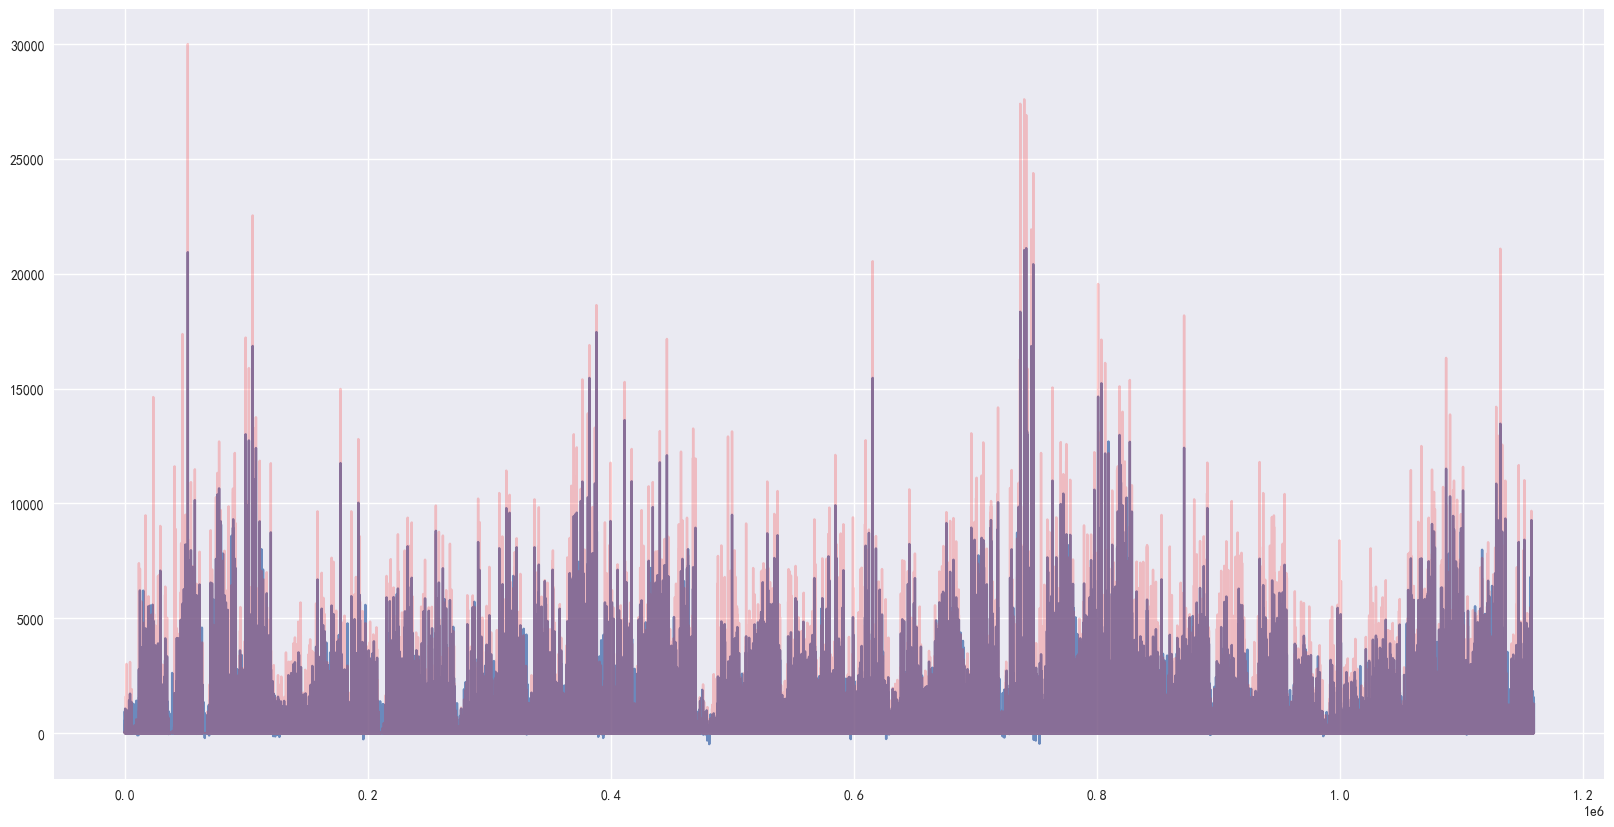

In [54]:
#y_hat = model.predict(X.values)
#print(y_hat)
# fig, ax = plt.subplots(2, 1)
fig = plt.figure(figsize=(20,10))
plt.plot(test_data[0],alpha=0.8)
plt.plot(y1.values,alpha=0.2,color='red')
from sklearn.metrics import r2_score
r2 = r2_score(y1.values, test_data[0])
print(r2)

In [55]:
from sklearn.metrics import mean_squared_error
import numpy as np


mse = mean_squared_error(y1.values,test_data[0])

# 计算均方根误差
rmse = np.sqrt(mse)
rmse

167.91682204488055

销售区域编码          False
产品编码            False
产品大类编码          False
产品细类编码          False
price_0         False
price_1         False
price_2         False
price_3         False
year            False
week            False
month           False
sales_0         False
sales_1         False
sales_2         False
sales_3         False
total_profit    False
季节              False
该月有无促销节日        False
线上线下占比          False
target          False
dtype: bool
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2619 entries, 0 to 2618
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   销售区域编码        2619 non-null   int64  
 1   产品编码          2619 non-null   int64  
 2   产品大类编码        2619 non-null   int64  
 3   产品细类编码        2619 non-null   int64  
 4   price_0       2619 non-null   float64
 5   price_1       2619 non-null   float64
 6   price_2       2619 non-null   float64
 7   price_3       2619 non-null   float64
 8   year  

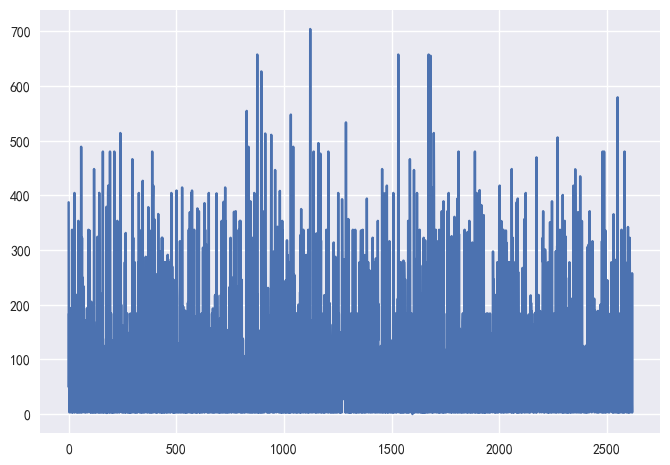

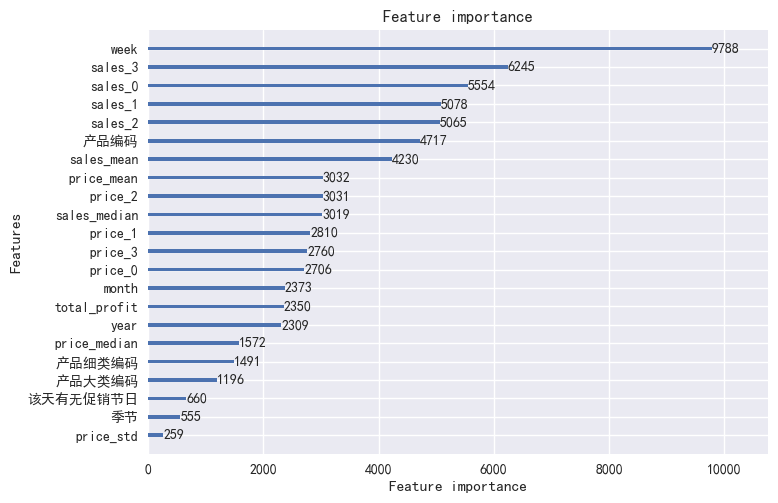

,销售区域编码,产品编码,产品大类编码,产品细类编码,订单需求量
0,101,20002,303,406,387.372474
1,101,20003,301,405,49.075778
2,101,20006,307,403,183.939343
3,101,20011,303,401,3.253223
4,101,20014,307,403,3.253223
...,...,...,...,...,...
2614,105,22066,307,403,30.277178
2615,105,22072,305,412,51.781321
2616,105,22075,307,403,3.253223
2617,105,22083,303,401,257.510620


In [56]:
melt_test_df['target'] = model.predict(melt_test_df.values,predict_disable_shape_check=True)
# melt_test_df.reset_index(inplace=True)
# melt_test_df['target'].plot()
result = pd.merge(
    final_test_df,
    melt_test_df,
    left_on=[
        '销售区域编码','产品编码','产品大类编码','产品细类编码'],
    right_on=[
        '销售区域编码','产品编码','产品大类编码','产品细类编码'],
    how='left')
print(result.isna().any())
print(result.info())
# result.fillna(0, inplace=True)
# result['ID'] = result.index
result.rename({'target': '订单需求量'}, inplace=True, axis=1)
result['订单需求量'].clip(0,inplace=True)
result['订单需求量'].plot()
# result[['ID', 'item_cnt_month']].to_csv('submission.csv', index=False)
lgb.plot_importance(model)
plt.show()
result[['销售区域编码','产品编码','产品大类编码','产品细类编码','订单需求量']]

In [57]:
importance = model.feature_importance(importance_type='split')
feature_name = model.feature_name()
for (feature_name,importance) in zip(feature_name,importance):
        print (feature_name,importance )


产品编码 4717
产品大类编码 1196
产品细类编码 1491
price_0 2706
price_1 2810
price_2 3031
price_3 2760
price_mean 3032
price_median 1572
price_std 259
year 2309
month 2373
week 9788
sales_0 5554
sales_1 5078
sales_2 5065
sales_3 6245
sales_mean 4230
sales_median 3019
sales_std 0
total_profit 2350
季节 555
该天有无促销节日 660


In [58]:
end_result = pd.DataFrame([])
end_result = result.copy(deep=True)
end_result = end_result[['销售区域编码','产品编码','产品大类编码','产品细类编码']]
for i in range(1,4):
    if i ==1:
        k=1
    elif i==2:
        k=5
    else:
        k=9
    week_result = pd.DataFrame([])
    for j in range(k,k+4):
        melt_test_df = pd.DataFrame([]) 
        id = sales_per_month.iloc[:, 0:feature_start_index]
        id.columns = ['销售区域编码','产品编码','产品大类编码','产品细类编码']  
        sales = sales_per_month.iloc[:, feature_start_index +
                                     one_catgory_feature_num -
                                     feature_loop_index:feature_start_index +
                                     one_catgory_feature_num]
        sales.columns = [f'sales_{a}' for a in range(feature_loop_index)]
        
        price = sales_per_month.iloc[:, feature_start_index +
                                     one_catgory_feature_num +
                                     one_catgory_feature_num -
                                     feature_loop_index:feature_start_index +
                                     one_catgory_feature_num +
                                     one_catgory_feature_num]
        price.columns = [f'price_{a}' for a in range(feature_loop_index)]
        total_profit= porudct_sum(sales,price,name='total_profit')
        price['year'] = 2019
        price['week']=j
        price['month'] =i
        melt_test_df = pd.concat([id, price, sales,total_profit], axis=1)
        melt_test_df['季节'] = melt_test_df['month'].apply(lambda x: 
                                            1 if x in [3, 4, 5] 
                                            else (2 if x in [6, 7, 8] 
                                            else (3 if x in [9, 10, 11] 
                                            else 4)))
        melt_test_df['该月有无促销节日'] = melt_test_df['month'].apply(lambda x: 
                                            1 if x in [1,3,6,10,11,12] 
                                            else 0)
        melt_test_df['线上线下占比'] = melt_test_df['销售区域编码'].apply(lambda x: 
                                            1 if x in [101,102,103] 
                                            else (2 if x in [104,105]
                                            else 0))
        melt_test_df.fillna(value=0,inplace=True)    
        #print(melt_test_df)
        melt_test_df['target'] = model.predict(melt_test_df.values,predict_disable_shape_check=True)
        result = pd.merge(
            final_test_df,
            melt_test_df,
            left_on=[
                '销售区域编码','产品编码','产品大类编码','产品细类编码'],
            right_on=[
                '销售区域编码','产品编码','产品大类编码','产品细类编码'],
            how='left')
#         result.rename({'target': '{}周订单需求量'.format(j)}, inplace=True, axis=1)       
#         week_result=pd.concat([week_result,result[['{}周订单需求量'.format(j)]]],axis=1)
#     end_result['{}月订单需求量'.format(i)] = week_result.iloc[:,0:4].sum(axis=1)
        result.rename({'target': '{}月订单需求量'.format(i)}, inplace=True, axis=1)
        result['{}月订单需求量'.format(i)].clip(0,inplace=True)
        end_result=pd.concat([end_result,result[['{}月订单需求量'.format(i)]]],axis=1)
    

In [59]:
end_result_end = end_result[['销售区域编码','产品编码','产品大类编码','产品细类编码']]

In [60]:
end_result_end['1月订单需求量']=round(end_result[['1月订单需求量']].sum(axis=1),0)
end_result_end['2月订单需求量']=round(end_result[['2月订单需求量']].sum(axis=1),0)
end_result_end['3月订单需求量']=round(end_result[['3月订单需求量']].sum(axis=1),0)

In [61]:
end_result_end

,销售区域编码,产品编码,产品大类编码,产品细类编码,1月订单需求量,2月订单需求量,3月订单需求量
0,101,20002,303,406,2345.0,2301.0,1549.0
1,101,20003,301,405,235.0,233.0,196.0
2,101,20006,307,403,874.0,872.0,736.0
3,101,20011,303,401,53.0,51.0,13.0
4,101,20014,307,403,53.0,51.0,13.0
...,...,...,...,...,...,...,...
2614,105,22066,307,403,126.0,125.0,121.0
2615,105,22072,305,412,336.0,335.0,207.0
2616,105,22075,307,403,53.0,51.0,13.0
2617,105,22083,303,401,1882.0,1838.0,1030.0


In [63]:
end_result_end.to_csv('./周粒度滑动预测结果.xlsx')